In [24]:
import os
import re
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

os.chdir('C:/Users/cg08900/Documents/Pandora/Personale/kaggle/NCAA_2k19/prog/functions/')

from ncaa19 import *

sns.set()

PATH_DATASETS = 'C:/Users/cg08900/Documents/Pandora/Personale/kaggle/NCAA_2k19/datasets/'
PATH_OUTPUT = 'C:/Users/cg08900/Documents/Pandora/Personale/kaggle/NCAA_2k19/datasets/'
PATH_ELAB = 'C:/Users/cg08900/Documents/Pandora/Personale/kaggle/NCAA_2k19/elaborazioni/'

REGRESSORS_TEAM = [
                   #'delta_ass_ratio_m', 'delta_tov_ratio_m', 
                   #'delta_reb_rate_m',
                   #'delta_opp_true_fg_pct',
                   'delta_net_rating_m', 
                   #'delta_opp_poss_s', 'delta_ass_ratio_s', 'delta_tov_ratio_s',
                   #'delta_reb_rate_s', 'delta_opp_true_fg_pct_s', 'delta_net_rating_s'
]

REGRESSORS_COACH = ['delta_c_N_season', 'delta_c_W_PCT_allT', 'delta_c_W_PCT_vs_topseeds_allT']

REGRESSORS_RANKING = ['delta_MOR', 'delta_POM','delta_SAG']

REGRESSORS = REGRESSORS_TEAM + REGRESSORS_COACH + REGRESSORS_RANKING

df_features_all = pd.read_csv(PATH_OUTPUT + '03Py_NCAA_dataset_con_indicatori.csv',
                              sep='|')

In [25]:
REGRESSORS

['delta_net_rating_m',
 'delta_c_N_season',
 'delta_c_W_PCT_allT',
 'delta_c_W_PCT_vs_topseeds_allT',
 'delta_MOR',
 'delta_POM',
 'delta_SAG']

In [29]:
from sklearn.linear_model import LogisticRegression
from sklearn.isotonic import IsotonicRegression
import numpy as np
from itertools import chain

def ir_fit(var_series, target_series):
  ir = IsotonicRegression(increasing="auto")
  ir.fit(var_series, target_series)
  return(ir)

def ir_apply(ir, var_series):
  return(pd.Series(ir.predict(var_series), index = var_series.index))

def ir_plot(var_base, var_iso, var_target, n_classes = 10):
  cl_x = pd.qcut(var_base, n_classes, labels = False, duplicates = 'drop')
  stats_td = var_target.groupby(cl_x).mean()
  stats_iso = var_iso.groupby(cl_x).mean()
  # plot figure
  fig = plt.figure()
  ax = fig.add_subplot(111)
  ax.plot(stats_td, 'bs-')
  ax.plot(stats_iso, 'rs-')
  ax.yaxis.grid(True, linestyle='--', linewidth=1)
  ax.xaxis.set_label_text("Percentili variabile X")
  ax.yaxis.set_label_text("Td")
  plt.show()

def logloss(y_hat, p_1win):
    n = len(y_hat)
    logloss = (-1/n) * sum((y_hat * np.log(p_1win)) + (1 - y_hat) * np.log(1 - p_1win))
    return(logloss)

def logistic(df_tr, features, target, df_valid=None, penalty='l2', C=1.0):
    X = df_tr.loc[:, features]
    y = df_tr.loc[:, target]
    sk_model = LogisticRegression(fit_intercept=True, penalty=penalty, C=C)\
        .fit(X, y)
    df_results = pd.DataFrame({'feature': ["(Intercept)"] + features,
                               'beta': sk_model.intercept_.tolist() + sk_model.coef_[0].tolist()})
    # print(df_results)
    if df_valid is not None:
        X_valid = df_valid.loc[:, features]
        y_valid = df_valid.loc[:, target]
        X_valid.fillna(0, inplace=True) # TODO: ask Stefano!
        p_valid = pd.Series(sk_model.predict_proba(X_valid)[:,1], index = y_valid.index)
        p_valid[p_valid >= 0.975] = 0.975
        p_valid[p_valid <= 0.075] = 0.025
        print(max(p_valid))
        print(min(p_valid))
        print("Log loss for test: {0}".format(logloss(y_valid, p_valid)))
        
    df_results['logloss'] = logloss(y_valid, p_valid)

    return df_results

def logistic_int(df_tr, features_t,
                 features_c, features_r, features_l,
                 target, df_valid=None, penalty='l2', C=1.0):
    # intg models
    X_t = df_tr.loc[:, features_t]
    X_c = df_tr.loc[:, features_c]
    X_r = df_tr.loc[:, features_r]
    X_l = df_tr.loc[:, features_l]
    y = df_tr.loc[:, target]
    
    
    sk_model_t = LogisticRegression(fit_intercept=True, penalty=penalty, C=C)\
        .fit(X_t, y)
    sk_model_c = LogisticRegression(fit_intercept=True, penalty=penalty, C=C)\
        .fit(X_c, y)
    sk_model_r = LogisticRegression(fit_intercept=True, penalty=penalty, C=C)\
        .fit(X_r, y)
    sk_model_l = LogisticRegression(fit_intercept=True, penalty=penalty, C=C)\
        .fit(X_l, y)
    
    pr_t = sk_model_t.predict_proba(X_t)[:,1]
    pr_c = sk_model_c.predict_proba(X_c)[:,1]
    pr_r = sk_model_r.predict_proba(X_r)[:,1]
    pr_l = sk_model_l.predict_proba(X_l)[:,1]
    
    X = pd.DataFrame({'pr_t':pr_t,
                      'pr_c':pr_c,
                      'pr_r':pr_r,
                      'pr_l':pr_l})

    features = ['pr_t', 'pr_c', 'pr_r', 'pr_l']
    
    sk_model = LogisticRegression(fit_intercept=True, penalty=penalty, C=C)\
        .fit(X, y)
    
    df_results_t = pd.DataFrame({'feature': ["(Intercept)"] + features_t,
                               'beta': sk_model_t.intercept_.tolist() + sk_model_t.coef_[0].tolist()})
    df_results_c = pd.DataFrame({'feature': ["(Intercept)"] + features_c,
                               'beta': sk_model_c.intercept_.tolist() + sk_model_c.coef_[0].tolist()})
    df_results_r = pd.DataFrame({'feature': ["(Intercept)"] + features_r,
                               'beta': sk_model_r.intercept_.tolist() + sk_model_r.coef_[0].tolist()})
    df_results_l = pd.DataFrame({'feature': ["(Intercept)"] + features_l,
                               'beta': sk_model_l.intercept_.tolist() + sk_model_l.coef_[0].tolist()})
    df_results = pd.DataFrame({'feature': ["(Intercept)"] + features,
                               'beta': sk_model.intercept_.tolist() + sk_model.coef_[0].tolist()})
    
    
    df_results_t['model'] = 'teams'
    df_results_c['model'] = 'coaches'
    df_results_r['model'] = 'rankings'
    df_results_l['model'] = 'last30days'
    
    print(df_results)
    if df_valid is not None:
        
        X_t_v = df_valid.loc[:, features_t]
        X_c_v = df_valid.loc[:, features_c]
        X_r_v = df_valid.loc[:, features_r]
        X_l_v = df_valid.loc[:, features_l]
        
        pr_t_v = sk_model_t.predict_proba(X_t_v)[:,1]
        pr_c_v = sk_model_c.predict_proba(X_c_v)[:,1]
        pr_r_v = sk_model_r.predict_proba(X_r_v)[:,1]
        pr_l_v = sk_model_l.predict_proba(X_l_v)[:,1]
        
        X_valid = pd.DataFrame({'pr_t':pr_t_v,
                                'pr_c':pr_c_v,
                                'pr_r':pr_r_v,
                                'pr_l':pr_l_v})
        
        y_valid = df_valid.loc[:, target]
        X_valid.fillna(0, inplace=True) # TODO: ask Stefano!
        p_valid = pd.Series(sk_model.predict_proba(X_valid)[:,1], index = y_valid.index)
        #p_valid[p_valid >= 0.975] = 0.975
        #p_valid[p_valid <= 0.025] = 0.025
        print(max(p_valid))
        print(min(p_valid))
        print("Log loss for test: {0}".format(logloss(y_valid, p_valid)))
        
    df_results['logloss'] = logloss(y_valid, p_valid)

    return df_results





In [34]:
## Train 4 years

for year_ in [0,1,2,3]:
    filter_train = (df_features_all['Season']>=2003) & (df_features_all['Season']<=2014+year_)
    filter_test = (df_features_all['Season'].isin([2015+year_]))
    df_train = df_features_all.loc[filter_train, :].copy()
    df_test = df_features_all.loc[filter_test, :].copy()
    df_train.fillna(0, inplace=True) 
    df_test.fillna(0, inplace=True)

    # apply isotonic transformation
    for regressor in REGRESSORS:
    
        # print("Transform feature {0}".format(regressor))
    
        ir_var = ir_fit(df_train[regressor], df_train['win_dummy'])
        df_train['piso_' + regressor] =\
          ir_apply(ir_var, df_train[regressor])
        df_test['piso_' + regressor] =\
          ir_apply(ir_var, df_test[regressor])
    
        # ir_plot(df_test[regressor],
        #         df_test['piso_' + regressor],
        #         df_test['win_dummy'], 25)
    print('testing on: ' + str(2015+year_))
    out_ = logistic(df_train, 
                    #['piso_' + r for r in REGRESSORS], 
                    REGRESSORS,
                    'win_dummy', df_test, penalty='l1', C=0.50)  
    
    out_['test_year'] = 2015+year_
    
    if year_ == 0:
        out_f = out_
    else:
        out_f = pd.concat([out_f, out_])

testing on: 2015
0.975
0.025
Log loss for test: 0.5542997337043188
testing on: 2016
0.9460884022490379
0.025
Log loss for test: 0.543031532201026
testing on: 2017
0.975
0.025
Log loss for test: 0.4959330967961257
testing on: 2018
0.9714208207715359
0.025
Log loss for test: 0.5863147902247194


In [7]:
out_f.to_excel(PATH_DATASETS + "08Py_NCAA_ciclo_primo_modello_lasso_isotonic_new.xlsx")

In [31]:
out_f

,feature,beta,logloss,test_year
0,(Intercept),0.027594,0.589850,2015
1,delta_net_rating_m,0.021774,0.589850,2015
2,delta_c_N_season,-0.062285,0.589850,2015
3,delta_c_W_PCT_allT,0.137499,0.589850,2015
4,delta_c_W_PCT_vs_topseeds_allT,0.000000,0.589850,2015
5,delta_MOR,-0.019654,0.589850,2015
6,delta_POM,0.009601,0.589850,2015
7,delta_SAG,-0.009160,0.589850,2015
0,(Intercept),0.021652,0.542283,2016
1,delta_net_rating_m,0.017677,0.542283,2016


In [ ]:
out_f.to_excel(PATH_DATASETS + "08Py_NCAA_ciclo_intg_modello_lasso_isotonic.xlsx")

In [12]:
# xgboost
import xgboost as xgb

# apply isotonic transformation
for regressor in REGRESSORS:

    # print("Transform feature {0}".format(regressor))

    ir_var = ir_fit(df_train[regressor], df_train['win_dummy'])
    df_train['piso_' + regressor] =\
      ir_apply(ir_var, df_train[regressor])
    df_test['piso_' + regressor] =\
      ir_apply(ir_var, df_test[regressor])
    

df_tr = df_train  
features = ['piso_' + r for r in REGRESSORS]
target = 'win_dummy'
df_valid = df_test

X = df_tr.loc[:, features]
y = df_tr.loc[:, target]
gbm = xgb.XGBClassifier(seed = 13, 
                        objective = 'binary:logistic', 
                       
                        max_depth=4, 
                       learning_rate=0.02, 
                       subsample = 0.90).fit(X, y)

df_results_gbm = pd.DataFrame({'feature': features,
                               'importance': gbm.feature_importances_})
# print(df_results)
if df_valid is not None:
    X_valid = df_valid.loc[:, features]
    y_valid = df_valid.loc[:, target]
    X_valid.fillna(0, inplace=True) # TODO: ask Stefano!
    p_valid = pd.Series(gbm.predict_proba(X_valid)[:,1], index = y_valid.index)
    p_valid[p_valid >= 0.975] = 0.975
    p_valid[p_valid <= 0.025] = 0.025
    print(max(p_valid))
    print(min(p_valid))
    print("Log loss for test: {0}".format(logloss(y_valid, p_valid)))
        
    df_results_gbm['logloss'] = logloss(y_valid, p_valid)

0.8686174750328064
0.09563067555427551
Log loss for test: 0.5383555020636587


C:\Users\cg08900\AppData\Local\Continuum\anaconda3\envs\py36\lib\site-packages\sklearn\isotonic.py:70: UserWarning: Confidence interval of the Spearman correlation coefficient spans zero. Determination of ``increasing`` may be suspect.
  warnings.warn("Confidence interval of the Spearman "
C:\Users\cg08900\AppData\Local\Continuum\anaconda3\envs\py36\lib\site-packages\sklearn\isotonic.py:70: UserWarning: Confidence interval of the Spearman correlation coefficient spans zero. Determination of ``increasing`` may be suspect.
  warnings.warn("Confidence interval of the Spearman "
C:\Users\cg08900\AppData\Local\Continuum\anaconda3\envs\py36\lib\site-packages\sklearn\isotonic.py:70: UserWarning: Confidence interval of the Spearman correlation coefficient spans zero. Determination of ``increasing`` may be suspect.
  warnings.warn("Confidence interval of the Spearman "
C:\Users\cg08900\AppData\Local\Continuum\anaconda3\envs\py36\lib\site-packages\sklearn\isotonic.py:70: UserWarning: Confidence 

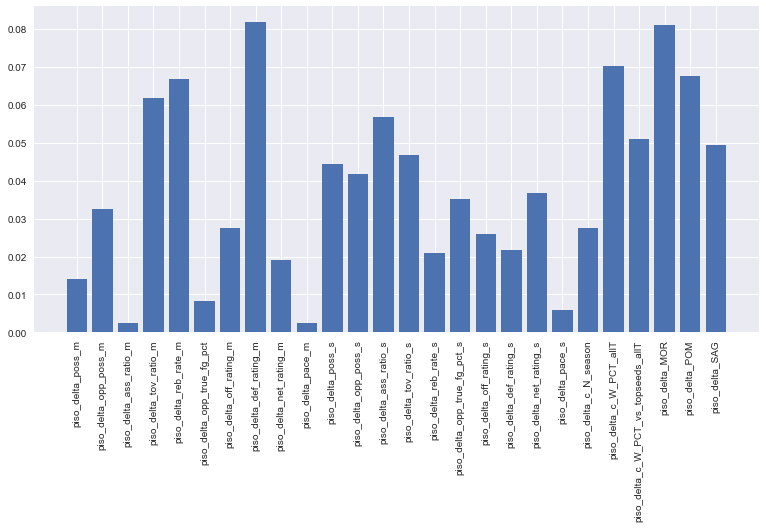

In [13]:
plt.figure(figsize=(13,6))
plt.bar(df_results_gbm['feature'], df_results_gbm['importance'])
plt.xticks(rotation='vertical')
plt.show()

In [11]:
df_train.columns

Index(['Season', 'DayNum', 'TeamID', 'TeamID_opp', 'Score_left', 'Score_right',
       'win_dummy', 'delta', 'NumOT', 'delta_poss_m', 'delta_opp_poss_m',
       'delta_ass_ratio_m', 'delta_tov_ratio_m', 'delta_reb_rate_m',
       'delta_opp_true_fg_pct', 'delta_off_rating_m', 'delta_def_rating_m',
       'delta_net_rating_m', 'delta_pace_m', 'delta_poss_s',
       'delta_opp_poss_s', 'delta_ass_ratio_s', 'delta_tov_ratio_s',
       'delta_reb_rate_s', 'delta_opp_true_fg_pct_s', 'delta_off_rating_s',
       'delta_def_rating_s', 'delta_net_rating_s', 'delta_pace_s',
       'delta_seed_int', 'delta_w_pct', 'delta_w_pct_H', 'delta_w_pct_N',
       'delta_w_pct_vs_topseeds', 'delta_c_N_season', 'delta_c_N_champ_W',
       'delta_c_W_PCT_allT', 'delta_c_W_PCT_vs_topseeds_allT', 'delta_MOR',
       'delta_POM', 'delta_SAG', 'piso_delta_poss_m', 'piso_delta_opp_poss_m',
       'piso_delta_ass_ratio_m', 'piso_delta_tov_ratio_m',
       'piso_delta_reb_rate_m', 'piso_delta_opp_true_fg_pct',
   